<a href="https://colab.research.google.com/github/supsi-dacd-isaac/teaching/blob/main/2021SmartGrids/S08%20-%20example%20battery%20control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# State space model definition
The following equations define a simple model for a battery with an asymmetric charging and discharging efficiency and a small self-discharge

In [97]:
dt = 60             # Sampling time [s]
eta_ch = 0.95   # charging efficiency
eta_ds = 0.95   # discharging efficiency
k = -np.log(0.97)/(86400*30) # self discharge of 3% in a month

# compute matrices in continous time
Ac = np.atleast_2d(-k)
Bc = np.atleast_2d(np.array([eta_ch, -1/eta_ds]))

# Exact discretization
Ad = np.exp(dt*Ac)
Bd = np.linalg.inv(Ac)@(Ad - 1)@Bc
print('Ad: {}\nBd: {}'.format(np.round(Ad, 5), np.round(Bd, 5)))

Ad: [[1.]]
Bd: [[ 56.99998 -63.15787]]


# Generate synthetic consumption and production time series
This is just an example, we will use dummy profiles

<Axes: >

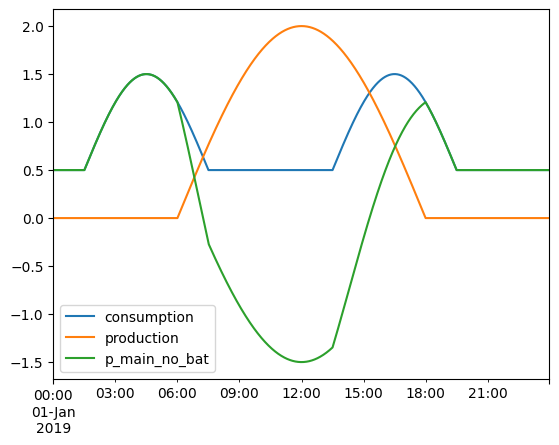

In [98]:
t=pd.date_range('2019-01-01','2019-01-01 23:59:00', freq='1min')
consumption = 0.5 + np.clip(np.sin(t.astype(int) / 10**9 / 86400 * 4 * np.pi - np.pi/4), 0, 1)
production = 2 * np.clip(-np.cos(t.astype(int) / 10**9 / 86400 * 2 * np.pi), 0, 1)
df = pd.DataFrame(index=t,data={'consumption': consumption, 'production': production, 'p_main_no_bat': consumption-production})
df.plot()

# Define battery controller
We define a very simple rule-based battery controller

In [99]:
def battery_control(p_main, x, dt, eta_ch, eta_ds, Ad, Bd, x_max=15, x_min=1, p_max=5):
  """
  Rule based controller for the battery
  p_main: current power at the household's main
  x: state of the battery in kWh
  eta_ch, eta_ds: charging and discharging efficiency of the battery
  x_max, x_min: maximum and minimum allowed state in kWh
  p_max: maxinum charging/discharging power (assuming 0 as minimum charging power)
  """
  # compute how much energy would flow in or out the battery, if it could
  # absorb / cover all the p_main (if it had infinite capacity (kWh))
  if p_main < 0:
    p = np.minimum(p_max, -p_main)
    e_batt = p * Bd[0, 0] / 3600
  else:
    p = np.minimum(p_max, p_main)
    e_batt = p * Bd[0, 1] / 3600

  # compute the hypotetical new state
  x_new = Ad[0] * x + e_batt

  # trim it according to the actual capacity limits of the battery
  x_new_corr = np.maximum(np.minimum(x_new,x_max), x_min)

  # re-compute the actual energy flowing to or from the battery
  x_change = x_new_corr-Ad[0]*x
  p_batt_actual = dt * (x_change/eta_ch if x_change>0 else x_change*eta_ds)

  return p_batt_actual, x_new_corr

# Run simulation
And store results in the df

,consumption,production,p_main_no_bat,p_bat,soc,p_main
2019-01-01 00:00:00,0.5,0.0,0.5,-0.5,2.991226,1.762863e-07
2019-01-01 00:01:00,0.5,0.0,0.5,-0.5,2.982452,1.762863e-07
2019-01-01 00:02:00,0.5,0.0,0.5,-0.5,2.973678,1.762863e-07
2019-01-01 00:03:00,0.5,0.0,0.5,-0.5,2.964904,1.762863e-07
2019-01-01 00:04:00,0.5,0.0,0.5,-0.5,2.956130,1.762863e-07


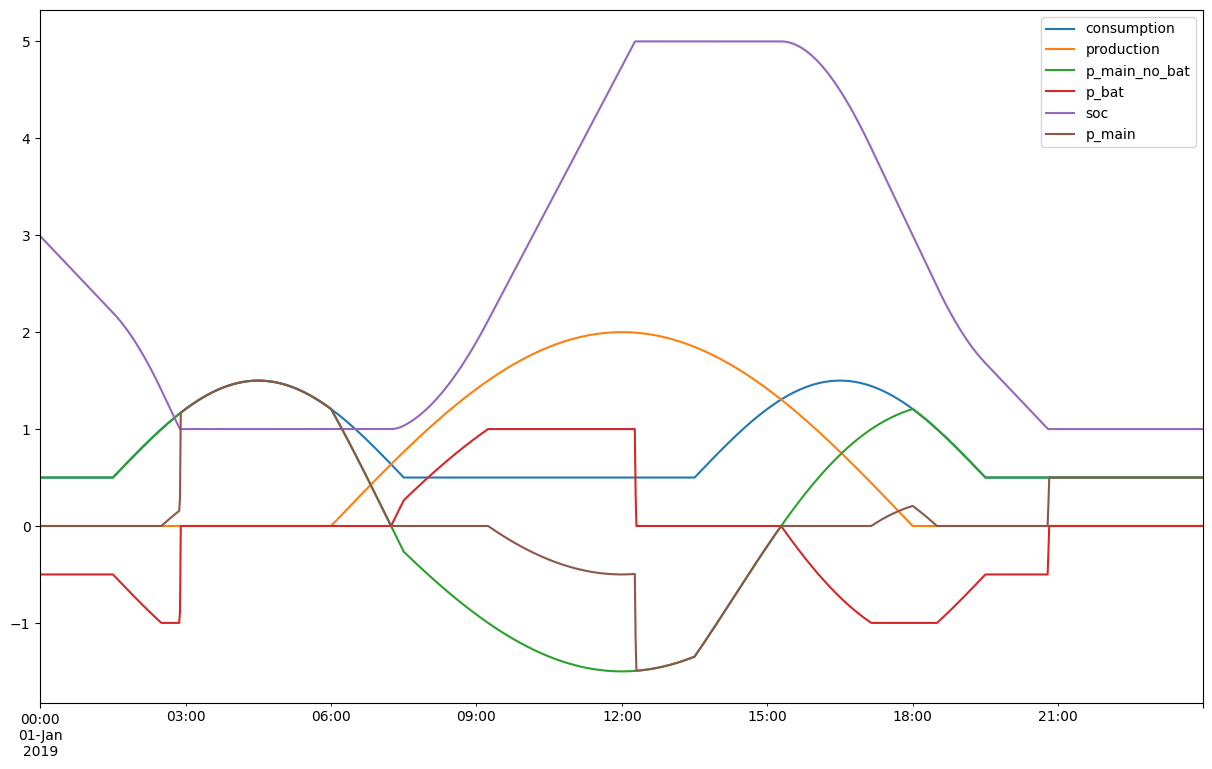

In [100]:
soc_max = 5
soc_min = 1
soc = 3
p_max = 1
for i in range(len(df)):
  p_bat, soc = battery_control(df.iloc[i]['p_main_no_bat'], soc, dt, eta_ch, eta_ds, Ad, Bd, x_max=soc_max, x_min=soc_min, p_max=p_max)
  df.loc[df.index[i], 'p_bat'] = p_bat
  df.loc[df.index[i], 'soc'] = soc
df['p_main'] = df['p_main_no_bat'] + df['p_bat']
df.plot(figsize=(15, 9))
df.head()